In [25]:
import cv2
from  matplotlib import pyplot as plt
import numpy as np
import os

image shape:  (600, 600)
enlarged shape:  (601, 601)


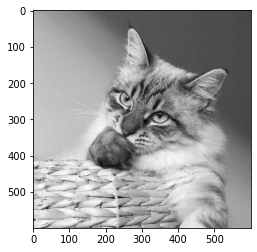

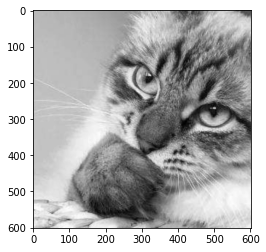

In [26]:
# readin picture
img_path = 'origin.jpeg'
enlarged_path = 'enlarged.jpeg'

img = cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB)
img_2 = cv2.cvtColor(cv2.imread(enlarged_path),cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
gray_2 = cv2.cvtColor(img_2,cv2.COLOR_RGB2GRAY)

print('image shape: ',gray.shape)
print('enlarged shape: ',gray_2.shape)

plt.imshow(gray, cmap ='gray')
plt.show()

plt.imshow(gray_2, cmap ='gray')
plt.show()

In [27]:
def Gaussian(x:int, y:int, sigma:float):
    return (np.exp(-(x**2+y**2)/(2*(sigma**2))))

# LoG
def LoG(x:int, y:int, sigma:float):
    return (x**2+y**2-2*(sigma**2))*Gaussian(x,y,sigma)/(sigma**2)

def get_kernel(sigma:float):
    kernel_size = 2*int(3*sigma)+1
    r = int((kernel_size-1)/2)
    conv_kernel = np.zeros((kernel_size,kernel_size))
    normal = 0 
    for i in range(kernel_size):
        for j in range(kernel_size):
            conv_kernel[i,j] = LoG(i-r,j-r,sigma)
            normal += Gaussian(i-r,j-r,sigma)
    conv_kernel = conv_kernel/normal
    return int(kernel_size),conv_kernel

# calculate conv
def conv(pic:np.ndarray, kernel:np.ndarray):
    h,w = pic.shape

    kernel_size,_ = kernel.shape
    kernel_r = int((kernel_size-1)/2)

    extend_gray = np.pad(pic,((kernel_r,kernel_r),(kernel_r,kernel_r)),'edge')

    result = np.zeros((h,w))
    for i in range(kernel_r,kernel_r+h):
        for j in range(kernel_r,kernel_r+w):
            result[i-kernel_r,j-kernel_r] = np.sum(np.multiply(extend_gray[i-kernel_r:i+kernel_r+1,j-kernel_r:j+kernel_r+1],kernel))
            # print(type(np.sum(np.multiply(extend_gray[i-kernel_r:i+kernel_r+1,j-kernel_r:j+kernel_r+1],kernel))))
    return result

In [28]:
# generate scale sapce
def generate_scale_space(gray,base_sigma=1.6,layer_num=5,picture_store=True,output=''):
    h,w = gray.shape
    if picture_store and not(os.path.exists('scale_space')):
        os.mkdir('scale_space')
    if picture_store and not(os.path.exists('scale_space/scale_space'+output)):
        os.mkdir('scale_space/scale_space'+output)
    kernel_sizes = np.zeros(layer_num) 
    scale_sapce = np.zeros((layer_num,h,w))

    for i in range(layer_num):
        kernel_sizes[i],kernel = get_kernel(base_sigma*2**i)
        scale_sapce[i] = conv(gray,kernel)
        # scale_sapce[i] = cv2.filter2D(gray,-1,kernel)
        # print(np.max(scale_sapce[i,:,:]),np.min(scale_sapce[i,:,:]))
        if picture_store:
            cv2.imwrite('scale_space/scale_space'+output+'/'+str(i)+output+'.png',scale_sapce[i])

    return scale_sapce

In [29]:
# get scale invariant points
def get_points(image,base_sigma=1.6,layer_num=5,picture_store=True,output=''):
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY).astype('float')
    scale_space = generate_scale_space(gray,base_sigma,layer_num,picture_store,output)
    points = []
    layer_num,h,w = scale_space.shape
    for i in range(1,layer_num-1):
        for j in range(1,h-1):
            for k in range(1,w-1):
                compare_matrix = scale_space[i-1:i+2,j-1:j+2,k-1:k+2]
                max_index = np.argmax(compare_matrix)
                if max_index==13:
                    position,_,_ = np.where(compare_matrix==compare_matrix[1,1,1])
                    if position.shape[0] == 1:
                        points.append(np.array([k,j,i]))
    color = [(255,0,0),(0,255,0),(0,0,255)]
    for point in points:
        cv2.circle(image,(int(point[0]),int(point[1])),int(base_sigma*2**point[2]),color[point[2]%3])
    if picture_store and not(os.path.exists('result')):
        os.mkdir('result')
    cv2.imwrite('result/result'+output+'.png',cv2.cvtColor(image,cv2.COLOR_RGB2BGR))
    plt.imshow(image)
    plt.show()
    return points

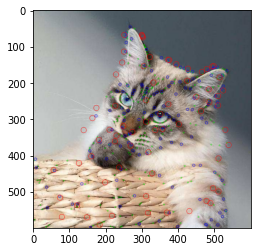

num of points:  424


In [30]:
# visualize
points = get_points(img,base_sigma=1,output="3")
# points_2 = get_points(img_2,base_sigma=1,output="2")
print('num of points: ', len(points))